In [2]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import joblib
# sys.modules['sklearn.externals.joblib'] = joblib
# from sklearn.preprocessing import Imputer
# sys.modules['sklearn.preprocessing.Imputer'] = Imputer
from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

In [3]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

In [4]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp 
def calculate_signalMod(r, L,e0):
    wave = few(M, mu, r, e0, theta, phi, dist=dist1, dt=dt, T=L)
    fft_plus = cp.fft.fft(wave.real)
    fft_corss = cp.fft.fft(wave.imag)
    power_spectrum_real = cp.abs(fft_plus) ** 2
    power_spectrum_imag = cp.abs(fft_corss) ** 2
    power_spectrum = power_spectrum_real + power_spectrum_imag
    return power_spectrum
    
def calculate_snr_profile(r_values, mu, T,e0):
    snr = []
    for r_val in r_values:
        signal_to = calculate_signalMod(r_val, 1/365,e0) 
        freq = np.logspace(-5, 0, len(signal_to))
        psd = power_spectral_density_RCLfit(freq)  
        templ = []
        for i in range(len(psd)):
            ratio = signal_to[i] / psd[i]
            templ.append(ratio)
        templ = cp.array(templ)
        sum_temp = cp.sum(templ)
        snr.append(cp.sqrt(sum_temp).get())  # Retrieve result from GPU and append to list
    return snr

def plot_snr_profile(r_values, snr_values, mu, T,e0):
    plt.figure()
    plt.plot(r_values, snr_values, '.')
    # Plot best fit line here if needed
    plt.xlabel('r')
    plt.title(f'SNR Profile for T = {T} years')
    plt.show()




In [6]:
# This block of code is setting up the initial conditions for generating a gravitational waveform.


M = 4.15e6 # mass of the black hole in solar masses
mu = 5e-2 # mass of the compact object in solar masses
dist1 = 0.000008277 # distance to the source in gigaparsecs
e0 = 0.0 # initial eccentricity
theta = np.pi / 2  # polar viewing angle
phi = 0  # azimuthal viewing angle
dt = 15 # time step in seconds
p0 = 9 # initial semilatus rectum in this case our orbit is circular. thus p =r = 6.15. 
t0 = 0.0 # initial time
T=0.000114155 # total time in years to generate the waveform here i take 1hr
# wave = few(M, mu, p0, e0, theta, phi, dist=dist1, dt=dt, T=T) # generate the waveform

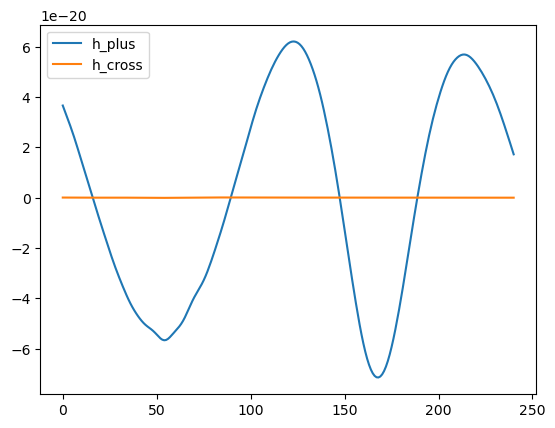

In [7]:
# plot waveform
plt.figure()
plt.plot(wave.real.get(), label='h_plus')
plt.plot(wave.imag.get(), label='h_cross')
plt.legend()
plt.show()


In this note book we will look into the change of the eccentricity and how the waveform changes.    

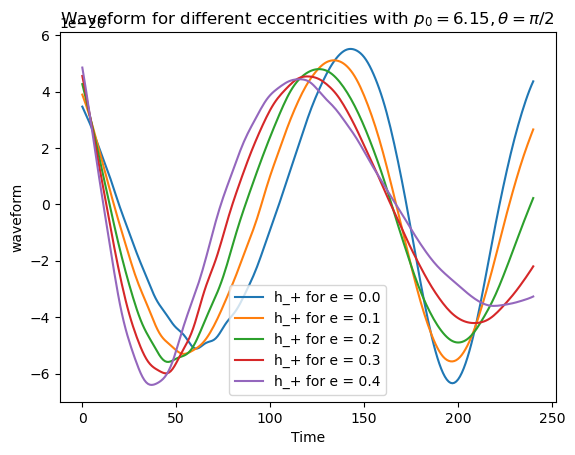

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define eccentricities
eccentricities = np.linspace(0, 0.4, 5)

# Generate waveforms and store them in a list
waveforms = []
for e in eccentricities:
    wave = few(M, mu, p0, e, theta, phi, dist=dist1, dt=dt, T=1/(365*24))
    waveforms.append(wave)

# Plot all waveforms
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real.get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 6.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()



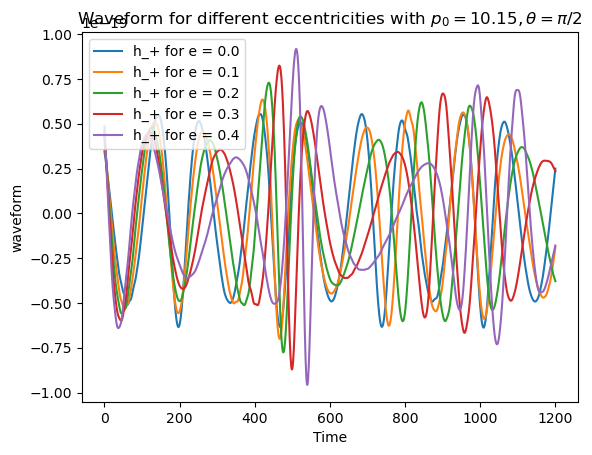

In [21]:
# Define eccentricities
eccentricities = np.linspace(0, 0.4, 5)

# Generate waveforms and store them in a list
waveforms = []
for e in eccentricities:
    wave = few(M, mu, 10, e, theta, phi, dist=dist1, dt=dt, T=5/(365*24))
    waveforms.append(wave)

# Plot all waveforms
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real.get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


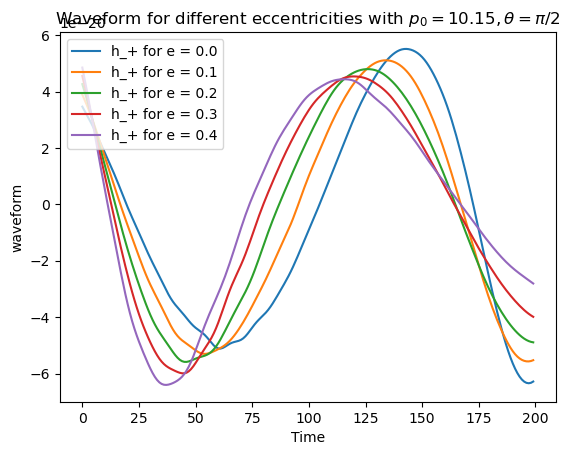

In [22]:
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real[:200].get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


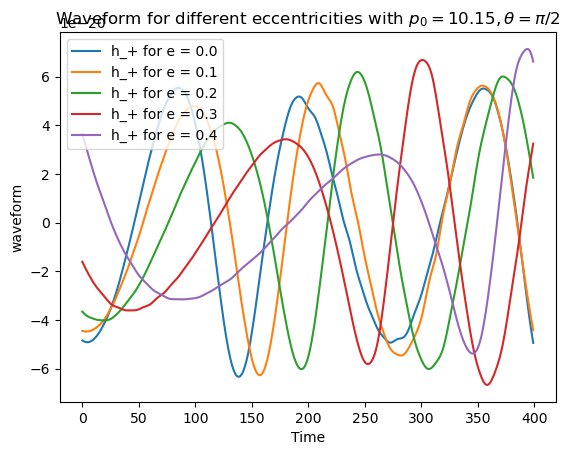

In [24]:
plt.figure()
for i, wave in enumerate(waveforms):
    plt.plot(wave.real[600:1000].get(), label=r'h_+ for e = {:.1f}'.format(eccentricities[i]))
    # plt.plot(wave.imag.get(), label='h_x for e = {:.1f}'.format(eccentricities[i]))
plt.title(r'Waveform for different eccentricities with $p_0 = 10.15, \theta=\pi/2 $')
plt.xlabel('Time')
plt.ylabel('waveform')
plt.legend()
plt.show()


In [9]:
# # i want to calculate snr for different values of e as r goes from 9 to 16.
# # i want to store them in a list and plot them in a graph.
# snr_valuesl = []

# for e in eccentricities:
#     r_values = np.linspace(9, 16, 10)
#         for r_val in r_values:
#             snr_values = calculate_snr_profile(r_val, mu, T,e)
#             snr_valuesl.append(snr_values)
# # Plot all snr values in a single graph with different colors and legends as e changes
# plt.figure()
# for i, snr_values in enumerate(snr_valuesl):
#     plt.plot(r_values, snr_values, label=r'SNR for e = {:.1f}'.format(eccentricities[i]))
# plt.legend()
# plt.show()

    

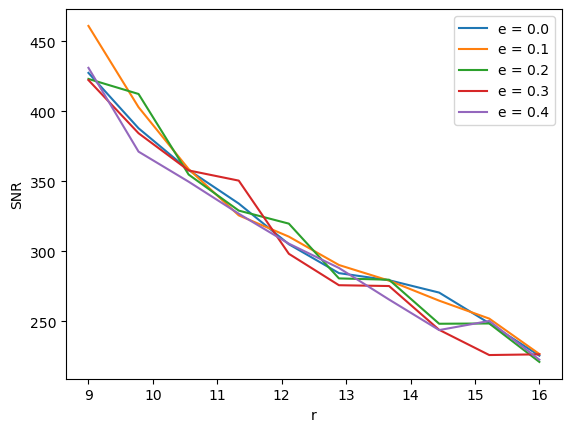

In [10]:
snr_valuesl = []

for e in eccentricities:
    r_values = np.linspace(9, 16, 10)
    snr_values = calculate_snr_profile(r_values, mu, T, e)
    snr_valuesl.append(snr_values)

# Plot all snr values in a single graph with different colors and legends as e changes
plt.figure()
for i, snr_values in enumerate(snr_valuesl):
    plt.plot(r_values, snr_values, label=r'e = {:.1f}'.format(eccentricities[i]))
plt.xlabel('r')
plt.ylabel('SNR')
plt.legend()
plt.show()



In [11]:


p0=10

eccentricities = np.linspace(0, 0.75,20)
snr_values = []

for e in eccentricities:
    r_values = np.linspace(10, 16, 10)
    snr_values = calculate_snr_profile(r_values, mu, T, e)
    snr_values.append(snr_values)



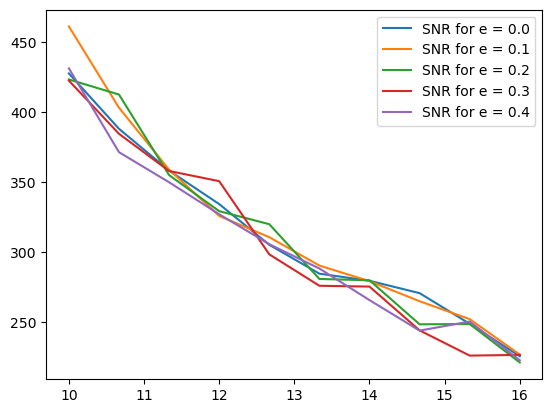

In [26]:
plt.figure()
for i, snr_values in enumerate(snr_valuesl):
    plt.plot(r_values, snr_values,  label=r'SNR for e = {:.1f}'.format(eccentricities[i]))
plt.legend()
plt.show()